In [87]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu

In [4]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=1, max_count=1000000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [5]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [6]:
SRP_name='aggregates'
#SRP_name='SRP217487'
resolution='10kbp_raw'
#df_jac_corr_list = []
#for resolution in ['100kbp_raw', '250kbp_raw', '10', 40 , 25, snhic]:
for resolution in ['10kbp_raw']:
    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{SRP_name}/{resolution}/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra_nanranked.h5'

    jac_sim_spr = hm.hiCMatrix(exp_file_path)




    all_genes_spr = [x[3].decode() for x in jac_sim_spr.cut_intervals]
    df_jac_corr = pd.DataFrame(jac_sim_spr.matrix.toarray() ,  index=all_genes_spr, columns = all_genes_spr)
    #df_jac_corr_list.append(pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes))
    
    #df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr_list[7])

In [7]:
SRP_name='aggregates'
resolution='40kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/mouse_prioAggNet.h5'

jac_exp = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_exp.cut_intervals]
df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)

In [8]:
import itertools
from itertools import permutations
def calc_auroc (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    rank_abs = lambda x: stats.rankdata(x)
    predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[predicted_score].values)
    df_trial['p'] = [y if x==1 else 0 for x,y in zip(df_trial['true_pos'], predicts2)]
    #print (df_trial['p'].sum())
    if df_trial['true_neg'].sum() == 0 or df_trial['true_pos'].sum() == 0:
        return np.nan
    else:
        return (((df_trial['p'].sum() /df_trial['true_pos'].sum() )- (df_trial['true_pos'].sum() + 1)/2)) / df_trial['true_neg'].sum()

In [17]:
SRP_name='aggregates'
#SRP_name='SRP217487'
resolution='40kbp_raw'
#df_jac_corr_list = []
#for resolution in ['100kbp_raw', '250kbp_raw', '10', 40 , 25, snhic]:
for resolution in ['40kbp_raw']:
    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{SRP_name}/{resolution}/max/hic_gene_inter_KR_nan_dummy.h5'

    jac_sim_dummy_bins = hm.hiCMatrix(exp_file_path)




    #all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
    #df_max_gene_whole = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)
    #df_jac_corr_list.append(pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes))

In [14]:
SRP_name='aggregates'
#SRP_name='SRP217487'
resolution='100kbp_raw'
#df_jac_corr_list = []
#for resolution in ['100kbp_raw', '250kbp_raw', '10', 40 , 25, snhic]:
for resolution in ['40kbp_raw']:
    exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{SRP_name}/{resolution}/max/hic_gene_inter_KR_nan.h5'

    jac_sim_dummy = hm.hiCMatrix(exp_file_path)




    #all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
    #df_max_gene_whole = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)
    #df_jac_corr_list.append(pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes))

In [15]:
import h5py
with h5py.File('/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/aggregates/40kbp_raw/max/hic_gene_inter_KR_nan_gene_by_allbins.h5', 'r') as hf:
        my_data= hf['gene_by_allbins'][()]
        

In [20]:
all_bins = [x[0]+'_'+str(int(x[1]/40000))  for x in jac_sim_dummy_bins.cut_intervals]



In [27]:
all_genes = [x[3].decode() for x in jac_sim_dummy.cut_intervals if x[3].decode() != 'non-gene']

In [31]:
my_data.shape

(50225, 61578)

In [32]:
df_max_gene_whole_by_bins = pd.DataFrame(my_data, index=all_genes, columns = all_bins)

In [56]:
for filename, col_names, filepath in zip(['GSE126074', 'BICCN2', 'GSE111586', 'GSE123576', 'GSE1303990'], [['OT','EX', 'IN', 'NA'], ['AC','EX','IN','OG','OT'], ['OT','EX', 'IN'], ['OT','EX', 'IN'], ['OT','EX', 'IN']], ['output_GSE126074_gene_global_index__all_scanpy_obj_clust_ave_celltype.bed', 'output_BICCN2_gene_global_index__all_scanpy_obj_clust_ave_celltype.bed','output_GSE111586_gene_global_index_5000__all_scanpy_obj_clust_ave_celltype.bed', 'output_GSE123576_gene_global_index_1000__all_scanpy_obj_clust_ave_celltype.bed', 'output_GSE1303990_gene_global_index_5000__all_scanpy_obj_clust_ave_celltype.bed']):

    

    atac_file_path= f"/grid/gillis/data/lohia/ATAC_Risa/celltype/{filepath}"
    
    comple_col = ['chr', 'start', 'end']
    
    comple_col.extend(col_names)
    
    print (comple_col)

    df = pd.read_csv(atac_file_path, sep='\t|,', skiprows=1, names=comple_col)

    df['start_bin'] = df['start'] / 40000

    df['start_bin'] = df['start'] / 40000
    df['end_bin'] = df['end'] / 40000

    df['start_bin'] = df['start_bin'].astype(int)
    df['end_bin'] = df['end_bin'].astype(int)
    
   

    df_atac = df.groupby(['chr','start_bin'])[col_names].sum().reset_index()
    
    df_atac['chr'] = df_atac['chr'].astype('str')
    df_atac['chr'] = 'chr' + df_atac['chr']

    df_atac['gene'] = df_atac['chr'] + '_'+df_atac['start_bin'].astype(str) 

    df_atac.to_csv(f'{filename}_40kb.csv', index=False)



['chr', 'start', 'end', 'OT', 'EX', 'IN', 'NA']


<ipython-input-56-2b9bd4ad9eac>:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(atac_file_path, sep='\t|,', skiprows=1, names=comple_col)


['chr', 'start', 'end', 'AC', 'EX', 'IN', 'OG', 'OT']
['chr', 'start', 'end', 'OT', 'EX', 'IN']
['chr', 'start', 'end', 'OT', 'EX', 'IN']
['chr', 'start', 'end', 'OT', 'EX', 'IN']


(377, 377)
(377, 2)
0.5
0.0


<ipython-input-173-921fcf43263e>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_atac = df_atac.groupby(['gene'])[group1, group2, 'tp_sum_pre', 'g_diff', 'tp_sum_pre2'].sum().reset_index()


['Non-Neuronal', 'GABAergic', 200, 0.6484612534612535, 0.6429608585858587, 4, 344, 41492, 0.7977509551843115]


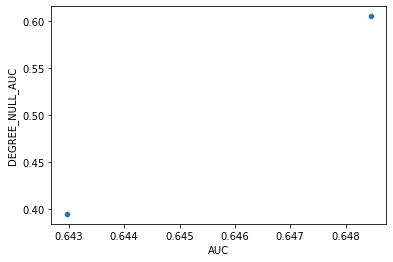

In [173]:
df_result_list_class = []
#list_1 = ['GABAergic', 'Non-Neuronal']
#list_1 = ['GABAergic', 'Non-Neuronal', 'Glutamatergic']
list_1 = ['Non-Neuronal', 'GABAergic']

#list_1 = ['GABAergic', 'Glutamatergic']
#list_1 = ['Glutamatergic', 'GABAergic']
for group1, group2 in list(itertools.combinations(list_1, 2)):
    
    

    #marker_list = marker_list[marker_list['rank'] <= 20] 
    #marker_list = marker_list[marker_list['rank'] == 50] 
    #marker_list = marker_list[marker_list['rank'].isin(list(range(0,51))+[1])] 
    
    for number_of_genes in [200]:
    
       #for given_matrix, given_matrix_name in zip([df_jac_corr, df_exp_corr], ['hic', 'exp']):
        
       for tp_thresh in [4]:
        
        df_result_list_pre = []
        
        marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
        marker_list['gene'] = marker_list['gene'].str.upper()

        marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 

        marker_list = marker_list[marker_list.cell_type.isin([group1, group2])]
        marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
        df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
        marker_list = marker_list.merge(df_ensg_name, right_on='gene', left_on='gene') 

        marker_table = marker_list.pivot_table(index='gene_id', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

        df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr)
        %matplotlib inline
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
        #plt.plot([0, 1], [0, 1], c='black')
        #plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
        #plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')


        
        df_max_gene_whole_by_bins_coding = df_max_gene_whole_by_bins.div(df_max_gene_whole_by_bins.mean(axis=1, skipna=True), axis=0)

        df_atac = pd.concat([pd.read_csv('BICCN2_40kb.csv'), pd.read_csv('GSE1303990_40kb.csv'), pd.read_csv('GSE123576_40kb.csv'), pd.read_csv('GSE126074_40kb.csv')])
        df_atac = df_atac.fillna(0)
        df_atac['Non-Neuronal'] = df_atac['AC'] + df_atac['OG'] + df_atac['OT']
        df_atac['GABAergic'] = df_atac['IN']
        df_atac['Glutamatergic'] = df_atac['EX']
        df_atac['g_diff'] = df_atac[group1] - df_atac[group2]
        df_atac['tp_sum_pre'] = [1 if x>0 else 0 for x in df_atac['g_diff']]
        df_atac['tp_sum_pre2'] = [1 if x<0 else 0 for x in df_atac['g_diff']]
        df_atac = df_atac.groupby(['gene'])[group1, group2, 'tp_sum_pre', 'g_diff', 'tp_sum_pre2'].sum().reset_index()


        df_max_gene_whole_by_bins_coding = df_max_gene_whole_by_bins_coding.T[df_max_gene_whole_by_bins_coding.columns.isin(df_atac['gene'].tolist())].T



        df_max_gene_whole_group_1 = df_max_gene_whole_by_bins_coding[df_max_gene_whole_by_bins_coding.index.isin(marker_table[marker_table[group1] == 1].index.tolist())]


        df_max_gene_whole_group_2 = df_max_gene_whole_by_bins_coding[df_max_gene_whole_by_bins_coding.index.isin(marker_table[marker_table[group2] == 1].index.tolist())]

        

        z_p_dict = []
        bin_id = []
        mean_val = []


        for column in df_max_gene_whole_group_1:
            bin_id.append(column)
            try:
                U, p_val = mannwhitneyu(df_max_gene_whole_group_1[column].dropna().tolist(), df_max_gene_whole_group_2[column].dropna().tolist(), alternative="two-sided")
                z_p_dict.append(p_val)

                mean_val.append((df_max_gene_whole_group_1[column].dropna().mean()-df_max_gene_whole_group_2[column].dropna().mean()))

            except:
                z_p_dict.append(np.nan)
                mean_val.append(np.nan)
                

        import statsmodels.api as sm
        auc_GO_terms_manw = pd.DataFrame(list(zip(bin_id,  z_p_dict , mean_val)), columns=['id', 'P_val_agg', 'mean_diff'])
        auc_GO_terms_manw['class'] = "gaba"
        

        
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)

        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        
        df_atac_hic = df_atac.merge(auc_GO_terms_manw, left_on='gene', right_on='id')
        
        

        df_atac_hic['true_pos'] = [1 if ((x>=tp_thresh) )  else 0 for x,y in zip(df_atac_hic['tp_sum_pre'], df_atac_hic[group1])] 
            
        df_atac_hic['true_neg'] = [0 if x==1 else 1 for x in df_atac_hic['true_pos']]
        
        #df_atac_hic['true_pos'] = [1 if ((x>=tp_thresh) ) else 0 for x,y in zip(df_atac_hic['tp_sum_pre'], df_atac_hic['tp_sum_pre2'])] 
            
        #df_atac_hic['true_neg'] = [0 if x==1 else 1 for x in df_atac_hic['true_pos']]



        df_atac_hic['p'] = 1 - df_atac_hic['adjusted_P_val_agg']


            
        
        df_result_list_pre.append(group1)
        df_result_list_pre.append(group2)
        df_result_list_pre.append(number_of_genes)
        df_result_list_pre.append(df_2d_jac['AUC'][group1])
        df_result_list_pre.append(df_2d_jac['AUC'][group2])
        df_result_list_pre.append(tp_thresh)
        df_result_list_pre.append(df_atac_hic['true_pos'].sum())
        df_result_list_pre.append(df_atac_hic[df_atac_hic['adjusted_P_val_agg']<0.05]['gene'].count())
        df_atac_hic['mean_diff_abs'] = [x if x> 0 else 0 for x in df_atac_hic['p'] ]
            
        df_result_list_pre.append(calc_auroc(df_atac_hic, predicted_score='mean_diff'))
        print (df_result_list_pre)
        df_result_list_class.append(df_result_list_pre)

 

(377, 377)
(377, 2)
0.5
0.0


<ipython-input-175-ca9119e45df5>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_atac = df_atac.groupby(['gene'])[group1, group2, 'tp_sum_pre', 'g_diff', 'tp_sum_pre2'].sum().reset_index()


['Non-Neuronal', 'GABAergic', 200, 0.6484612534612535, 0.6429608585858587, 4, 50, 41492, 0.9428021153076205]


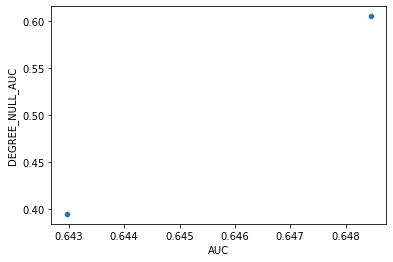

In [175]:
df_result_list_class = []
#list_1 = ['GABAergic', 'Non-Neuronal']
#list_1 = ['GABAergic', 'Non-Neuronal', 'Glutamatergic']
list_1 = ['Non-Neuronal', 'GABAergic']

#list_1 = ['GABAergic', 'Glutamatergic']
#list_1 = ['Glutamatergic', 'GABAergic']
for group1, group2 in list(itertools.combinations(list_1, 2)):
    
    

    #marker_list = marker_list[marker_list['rank'] <= 20] 
    #marker_list = marker_list[marker_list['rank'] == 50] 
    #marker_list = marker_list[marker_list['rank'].isin(list(range(0,51))+[1])] 
    
    for number_of_genes in [200]:
    
       #for given_matrix, given_matrix_name in zip([df_jac_corr, df_exp_corr], ['hic', 'exp']):
        
       for tp_thresh in [4]:
        
        df_result_list_pre = []
        
        marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
        marker_list['gene'] = marker_list['gene'].str.upper()

        marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 

        marker_list = marker_list[marker_list.cell_type.isin([group1, group2])]
        marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
        df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
        marker_list = marker_list.merge(df_ensg_name, right_on='gene', left_on='gene') 

        marker_table = marker_list.pivot_table(index='gene_id', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

        df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr)
        %matplotlib inline
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
        #plt.plot([0, 1], [0, 1], c='black')
        #plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
        #plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')


        
        df_max_gene_whole_by_bins_coding = df_max_gene_whole_by_bins.div(df_max_gene_whole_by_bins.mean(axis=1, skipna=True), axis=0)

        df_atac = pd.concat([pd.read_csv('BICCN2_40kb.csv'), pd.read_csv('GSE1303990_40kb.csv'), pd.read_csv('GSE123576_40kb.csv'), pd.read_csv('GSE126074_40kb.csv')])
        df_atac = df_atac.fillna(0)
        df_atac['Non-Neuronal'] = df_atac['AC'] + df_atac['OG'] + df_atac['OT']
        df_atac['GABAergic'] = df_atac['IN']
        df_atac['Glutamatergic'] = df_atac['EX']
        df_atac['g_diff'] = df_atac[group1] - df_atac[group2]
        df_atac['tp_sum_pre'] = [1 if x>0 else 0 for x in df_atac['g_diff']]
        df_atac['tp_sum_pre2'] = [1 if x<0 else 0 for x in df_atac['g_diff']]
        df_atac = df_atac.groupby(['gene'])[group1, group2, 'tp_sum_pre', 'g_diff', 'tp_sum_pre2'].sum().reset_index()


        df_max_gene_whole_by_bins_coding = df_max_gene_whole_by_bins_coding.T[df_max_gene_whole_by_bins_coding.columns.isin(df_atac['gene'].tolist())].T



        df_max_gene_whole_group_1 = df_max_gene_whole_by_bins_coding[df_max_gene_whole_by_bins_coding.index.isin(marker_table[marker_table[group1] == 1].index.tolist())]


        df_max_gene_whole_group_2 = df_max_gene_whole_by_bins_coding[df_max_gene_whole_by_bins_coding.index.isin(marker_table[marker_table[group2] == 1].index.tolist())]

        

        z_p_dict = []
        bin_id = []
        mean_val = []


        for column in df_max_gene_whole_group_1:
            bin_id.append(column)
            try:
                U, p_val = mannwhitneyu(df_max_gene_whole_group_1[column].dropna().tolist(), df_max_gene_whole_group_2[column].dropna().tolist(), alternative="two-sided")
                z_p_dict.append(p_val)

                mean_val.append((df_max_gene_whole_group_1[column].dropna().mean()-df_max_gene_whole_group_2[column].dropna().mean()))

            except:
                z_p_dict.append(np.nan)
                mean_val.append(np.nan)
                

        import statsmodels.api as sm
        auc_GO_terms_manw = pd.DataFrame(list(zip(bin_id,  z_p_dict , mean_val)), columns=['id', 'P_val_agg', 'mean_diff'])
        auc_GO_terms_manw['class'] = "gaba"
        

        
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)

        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        
        df_atac_hic = df_atac.merge(auc_GO_terms_manw, left_on='gene', right_on='id')
        
        

        df_atac_hic['true_pos'] = [1 if ((x>=3) )  else 0 for x,y in zip(df_atac_hic[group1], df_atac_hic[group1])] 
            
        df_atac_hic['true_neg'] = [0 if x==1 else 1 for x in df_atac_hic['true_pos']]
        
        #df_atac_hic['true_pos'] = [1 if ((x>=tp_thresh) ) else 0 for x,y in zip(df_atac_hic['tp_sum_pre'], df_atac_hic['tp_sum_pre2'])] 
            
        #df_atac_hic['true_neg'] = [0 if x==1 else 1 for x in df_atac_hic['true_pos']]



        df_atac_hic['p'] = 1 - df_atac_hic['adjusted_P_val_agg']


            
        
        df_result_list_pre.append(group1)
        df_result_list_pre.append(group2)
        df_result_list_pre.append(number_of_genes)
        df_result_list_pre.append(df_2d_jac['AUC'][group1])
        df_result_list_pre.append(df_2d_jac['AUC'][group2])
        df_result_list_pre.append(tp_thresh)
        df_result_list_pre.append(df_atac_hic['true_pos'].sum())
        df_result_list_pre.append(df_atac_hic[df_atac_hic['adjusted_P_val_agg']<0.05]['gene'].count())
        df_atac_hic['mean_diff_abs'] = [x if x> 0 else 0 for x in df_atac_hic['p'] ]
            
        df_result_list_pre.append(calc_auroc(df_atac_hic, predicted_score='mean_diff'))
        print (df_result_list_pre)
        df_result_list_class.append(df_result_list_pre)

 

(377, 377)
(377, 2)
0.5
0.0


<ipython-input-176-ef6f21ac2700>:63: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_atac = df_atac.groupby(['gene'])[group1, group2, 'tp_sum_pre', 'g_diff', 'tp_sum_pre2'].sum().reset_index()


['GABAergic', 'Non-Neuronal', 200, 0.6429608585858587, 0.6484612534612535, 4, 127, 41492, 0.07445007035937536]


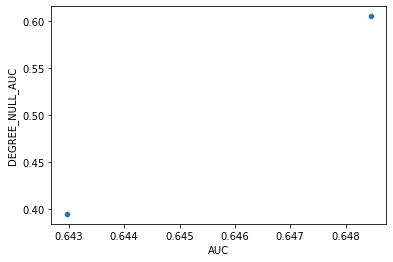

In [176]:
df_result_list_class = []
list_1 = ['GABAergic', 'Non-Neuronal']
#list_1 = ['GABAergic', 'Non-Neuronal', 'Glutamatergic']
#list_1 = ['Non-Neuronal', 'GABAergic']

#list_1 = ['GABAergic', 'Glutamatergic']
#list_1 = ['Glutamatergic', 'GABAergic']
for group1, group2 in list(itertools.combinations(list_1, 2)):
    
    

    #marker_list = marker_list[marker_list['rank'] <= 20] 
    #marker_list = marker_list[marker_list['rank'] == 50] 
    #marker_list = marker_list[marker_list['rank'].isin(list(range(0,51))+[1])] 
    
    for number_of_genes in [200]:
    
       #for given_matrix, given_matrix_name in zip([df_jac_corr, df_exp_corr], ['hic', 'exp']):
        
       for tp_thresh in [4]:
        
        df_result_list_pre = []
        
        marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
        marker_list['gene'] = marker_list['gene'].str.upper()

        marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 

        marker_list = marker_list[marker_list.cell_type.isin([group1, group2])]
        marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
        df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
        marker_list = marker_list.merge(df_ensg_name, right_on='gene', left_on='gene') 

        marker_table = marker_list.pivot_table(index='gene_id', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

        df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr)
        %matplotlib inline
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
        #plt.plot([0, 1], [0, 1], c='black')
        #plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
        #plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')


        
        df_max_gene_whole_by_bins_coding = df_max_gene_whole_by_bins.div(df_max_gene_whole_by_bins.mean(axis=1, skipna=True), axis=0)

        df_atac = pd.concat([pd.read_csv('BICCN2_40kb.csv'), pd.read_csv('GSE1303990_40kb.csv'), pd.read_csv('GSE123576_40kb.csv'), pd.read_csv('GSE126074_40kb.csv')])
        df_atac = df_atac.fillna(0)
        df_atac['Non-Neuronal'] = df_atac['AC'] + df_atac['OG'] + df_atac['OT']
        df_atac['GABAergic'] = df_atac['IN']
        df_atac['Glutamatergic'] = df_atac['EX']
        df_atac['g_diff'] = df_atac[group1] - df_atac[group2]
        df_atac['tp_sum_pre'] = [1 if x>0 else 0 for x in df_atac['g_diff']]
        df_atac['tp_sum_pre2'] = [1 if x<0 else 0 for x in df_atac['g_diff']]
        df_atac = df_atac.groupby(['gene'])[group1, group2, 'tp_sum_pre', 'g_diff', 'tp_sum_pre2'].sum().reset_index()


        df_max_gene_whole_by_bins_coding = df_max_gene_whole_by_bins_coding.T[df_max_gene_whole_by_bins_coding.columns.isin(df_atac['gene'].tolist())].T



        df_max_gene_whole_group_1 = df_max_gene_whole_by_bins_coding[df_max_gene_whole_by_bins_coding.index.isin(marker_table[marker_table[group1] == 1].index.tolist())]


        df_max_gene_whole_group_2 = df_max_gene_whole_by_bins_coding[df_max_gene_whole_by_bins_coding.index.isin(marker_table[marker_table[group2] == 1].index.tolist())]

        

        z_p_dict = []
        bin_id = []
        mean_val = []


        for column in df_max_gene_whole_group_1:
            bin_id.append(column)
            try:
                U, p_val = mannwhitneyu(df_max_gene_whole_group_1[column].dropna().tolist(), df_max_gene_whole_group_2[column].dropna().tolist(), alternative="two-sided")
                z_p_dict.append(p_val)

                mean_val.append((df_max_gene_whole_group_1[column].dropna().mean()-df_max_gene_whole_group_2[column].dropna().mean()))

            except:
                z_p_dict.append(np.nan)
                mean_val.append(np.nan)
                

        import statsmodels.api as sm
        auc_GO_terms_manw = pd.DataFrame(list(zip(bin_id,  z_p_dict , mean_val)), columns=['id', 'P_val_agg', 'mean_diff'])
        auc_GO_terms_manw['class'] = "gaba"
        

        
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)

        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        
        df_atac_hic = df_atac.merge(auc_GO_terms_manw, left_on='gene', right_on='id')
        
        

        df_atac_hic['true_pos'] = [1 if ((x>=3) )  else 0 for x,y in zip(df_atac_hic[group1], df_atac_hic[group1])] 
            
        df_atac_hic['true_neg'] = [0 if x==1 else 1 for x in df_atac_hic['true_pos']]
        
        #df_atac_hic['true_pos'] = [1 if ((x>=tp_thresh) ) else 0 for x,y in zip(df_atac_hic['tp_sum_pre'], df_atac_hic['tp_sum_pre2'])] 
            
        #df_atac_hic['true_neg'] = [0 if x==1 else 1 for x in df_atac_hic['true_pos']]



        df_atac_hic['p'] = 1 - df_atac_hic['adjusted_P_val_agg']


            
        
        df_result_list_pre.append(group1)
        df_result_list_pre.append(group2)
        df_result_list_pre.append(number_of_genes)
        df_result_list_pre.append(df_2d_jac['AUC'][group1])
        df_result_list_pre.append(df_2d_jac['AUC'][group2])
        df_result_list_pre.append(tp_thresh)
        df_result_list_pre.append(df_atac_hic['true_pos'].sum())
        df_result_list_pre.append(df_atac_hic[df_atac_hic['adjusted_P_val_agg']<0.05]['gene'].count())
        df_atac_hic['mean_diff_abs'] = [x if x> 0 else 0 for x in df_atac_hic['p'] ]
            
        df_result_list_pre.append(calc_auroc(df_atac_hic, predicted_score='mean_diff'))
        print (df_result_list_pre)
        df_result_list_class.append(df_result_list_pre)

 

In [167]:
import h5py
with h5py.File('/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/aggregates/25kbp_raw/max/hic_gene_inter_KR_nan_gene_by_allbins.h5', 'r') as hf:
        my_data= hf['gene_by_allbins'][()]

In [168]:
my_data.shape

(50225, 98520)

(383, 383)
(383, 2)
0.5
0.0
['Lamp5', 'Pvalb', 200, 0.6062119227922337, 0.6053164520496644, 30501]
(359, 359)
(359, 2)
0.5
0.0
['Lamp5', 'Sncg', 200, 0.5524181568380463, 0.4802600588556145, 30501]
(383, 383)
(383, 2)
0.5
0.0
['Lamp5', 'Sst', 200, 0.5061772129075054, 0.4602629981145943, 30501]
(376, 376)
(376, 2)
0.5
0.0
['Lamp5', 'Vip', 200, 0.5066433657621299, 0.4702801748271325, 30501]
(356, 356)
(356, 2)
0.5
0.0
['Lamp5', 'L2/3 IT', 200, 0.4425979994371902, 0.44908251620095535, 30501]
(362, 362)
(362, 2)
0.5
0.0
['Lamp5', 'L5 ET', 200, 0.5465101621424805, 0.535214424951267, 30501]
(368, 368)
(368, 2)
0.5
0.0
['Lamp5', 'L5 IT', 200, 0.4774307643247635, 0.4959558208014496, 30501]
(360, 360)
(360, 2)
0.5
0.0
['Lamp5', 'L5/6 NP', 200, 0.4653605275607334, 0.49933851286559744, 30501]
(344, 344)
(344, 2)
0.5
0.0
['Lamp5', 'L6 CT', 200, 0.5569836293974225, 0.551724763979666, 30501]
(367, 367)
(367, 2)
0.5
0.0
['Lamp5', 'L6 IT', 200, 0.5708047282239178, 0.5738283478683587, 30501]
(360, 360)


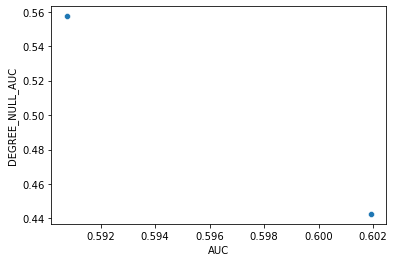

In [157]:
df_result_list_subclass = []
list_1 = ['Lamp5',
 'Pvalb',
 'Sncg',
 'Sst',
 'Vip',
 'L2/3 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b']

#list_1 = ['GABAergic', 'Glutamatergic']
#list_1 = ['Glutamatergic', 'GABAergic']
for group1, group2 in list(itertools.combinations(list_1, 2)):
    
    

    #marker_list = marker_list[marker_list['rank'] <= 20] 
    #marker_list = marker_list[marker_list['rank'] == 50] 
    #marker_list = marker_list[marker_list['rank'].isin(list(range(0,51))+[1])] 
    
    for number_of_genes in [200]:
    
       #for given_matrix, given_matrix_name in zip([df_jac_corr, df_exp_corr], ['hic', 'exp']):
        
       for tp_thresh in [4]:
        
        df_result_list_pre = []
        
        marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')
        marker_list['gene'] = marker_list['gene'].str.upper()

        marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 

        marker_list = marker_list[marker_list.cell_type.isin([group1, group2])]
        marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
        df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
        marker_list = marker_list.merge(df_ensg_name, right_on='gene', left_on='gene') 

        marker_table = marker_list.pivot_table(index='gene_id', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

        df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr)
        %matplotlib inline
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
        #plt.plot([0, 1], [0, 1], c='black')
        #plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
        #plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')


        
        df_max_gene_whole_by_bins_coding = df_max_gene_whole_by_bins.div(df_max_gene_whole_by_bins.mean(axis=1, skipna=True), axis=0)


        df_max_gene_whole_by_bins_coding = df_max_gene_whole_by_bins_coding.T[df_max_gene_whole_by_bins_coding.columns.isin(df_atac['gene'].tolist())].T



        df_max_gene_whole_group_1 = df_max_gene_whole_by_bins_coding[df_max_gene_whole_by_bins_coding.index.isin(marker_table[marker_table[group1] == 1].index.tolist())]


        df_max_gene_whole_group_2 = df_max_gene_whole_by_bins_coding[df_max_gene_whole_by_bins_coding.index.isin(marker_table[marker_table[group2] == 1].index.tolist())]

        

        z_p_dict = []
        bin_id = []
        mean_val = []


        for column in df_max_gene_whole_group_1:
            bin_id.append(column)
            try:
                U, p_val = mannwhitneyu(df_max_gene_whole_group_1[column].dropna().tolist(), df_max_gene_whole_group_2[column].dropna().tolist(), alternative="greater")
                z_p_dict.append(p_val)

                mean_val.append((df_max_gene_whole_group_1[column].dropna().mean()-df_max_gene_whole_group_2[column].dropna().mean()))

            except:
                z_p_dict.append(np.nan)
                mean_val.append(np.nan)
                

        import statsmodels.api as sm
        auc_GO_terms_manw = pd.DataFrame(list(zip(bin_id,  z_p_dict , mean_val)), columns=['id', 'P_val_agg', 'mean_diff'])
        auc_GO_terms_manw['class'] = "gaba"
        

        
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)

        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        

        
        df_result_list_pre.append(group1)
        df_result_list_pre.append(group2)
        df_result_list_pre.append(number_of_genes)
        df_result_list_pre.append(df_2d_jac['AUC'][group1])
        df_result_list_pre.append(df_2d_jac['AUC'][group2])


        df_result_list_pre.append(auc_GO_terms_manw[auc_GO_terms_manw['adjusted_P_val_agg']<0.05]['gene'].count())

            

        print (df_result_list_pre)
        df_result_list_subclass.append(df_result_list_pre)

 

(383, 383)
(383, 2)
0.5
0.0


KeyError: 'gene'

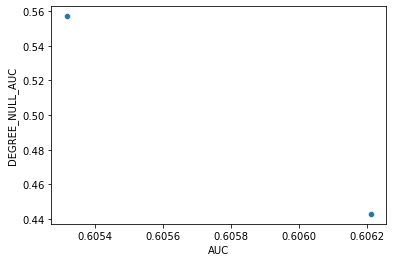

In [158]:
df_result_list_subclass = []
list_1 = ['Lamp5',
 'Pvalb',
 'Sncg',
 'Sst',
 'Vip',
 'L2/3 IT',
 'L5 ET',
 'L5 IT',
 'L5/6 NP',
 'L6 CT',
 'L6 IT',
 'L6 IT Car3',
 'L6b']

#list_1 = ['GABAergic', 'Glutamatergic']
#list_1 = ['Glutamatergic', 'GABAergic']
for group1, group2 in list(itertools.combinations(list_1, 2)):
    
    

    #marker_list = marker_list[marker_list['rank'] <= 20] 
    #marker_list = marker_list[marker_list['rank'] == 50] 
    #marker_list = marker_list[marker_list['rank'].isin(list(range(0,51))+[1])] 
    
    for number_of_genes in [200]:
    
       #for given_matrix, given_matrix_name in zip([df_jac_corr, df_exp_corr], ['hic', 'exp']):
        
       for tp_thresh in [4]:
        
        df_result_list_pre = []
        
        marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')
        marker_list['gene'] = marker_list['gene'].str.upper()

        marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 

        marker_list = marker_list[marker_list.cell_type.isin([group1, group2])]
        marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
        df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
        marker_list = marker_list.merge(df_ensg_name, right_on='gene', left_on='gene') 

        marker_table = marker_list.pivot_table(index='gene_id', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

        df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr)
        %matplotlib inline
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
        #plt.plot([0, 1], [0, 1], c='black')
        #plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
        #plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')


        
        df_max_gene_whole_by_bins_coding = df_max_gene_whole_by_bins.div(df_max_gene_whole_by_bins.mean(axis=1, skipna=True), axis=0)


        df_max_gene_whole_by_bins_coding = df_max_gene_whole_by_bins_coding.T[df_max_gene_whole_by_bins_coding.columns.isin(df_atac['gene'].tolist())].T



        df_max_gene_whole_group_1 = df_max_gene_whole_by_bins_coding[df_max_gene_whole_by_bins_coding.index.isin(marker_table[marker_table[group1] == 1].index.tolist())]


        df_max_gene_whole_group_2 = df_max_gene_whole_by_bins_coding[df_max_gene_whole_by_bins_coding.index.isin(marker_table[marker_table[group2] == 1].index.tolist())]

        

        z_p_dict = []
        bin_id = []
        mean_val = []


        for column in df_max_gene_whole_group_1:
            bin_id.append(column)
            try:
                U, p_val = mannwhitneyu(df_max_gene_whole_group_1[column].dropna().tolist(), df_max_gene_whole_group_2[column].dropna().tolist(), alternative="greater")
                z_p_dict.append(p_val)

                mean_val.append((df_max_gene_whole_group_1[column].dropna().mean()-df_max_gene_whole_group_2[column].dropna().mean()))

            except:
                z_p_dict.append(np.nan)
                mean_val.append(np.nan)
                

        import statsmodels.api as sm
        auc_GO_terms_manw = pd.DataFrame(list(zip(bin_id,  z_p_dict , mean_val)), columns=['id', 'P_val_agg', 'mean_diff'])
        auc_GO_terms_manw['class'] = "gaba"
        

        
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)

        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        

        
        df_result_list_pre.append(group1)
        df_result_list_pre.append(group2)
        df_result_list_pre.append(number_of_genes)
        df_result_list_pre.append(df_2d_jac['AUC'][group1])
        df_result_list_pre.append(df_2d_jac['AUC'][group2])


        df_result_list_pre.append(auc_GO_terms_manw[auc_GO_terms_manw['adjusted_P_val_agg']<0.05]['class'].count())

            

        print (df_result_list_pre)
        df_result_list_subclass.append(df_result_list_pre)

 

In [159]:
auc_GO_terms_manw

id  P_val_agg  mean_diff class  adjusted_P_val_agg
0         chr1_75   0.016711   0.066948  gaba            0.077667
1         chr1_76   0.004774   0.082777  gaba            0.038841
2         chr1_77   0.004716   0.082932  gaba            0.038659
3         chr1_78   0.021038   0.042600  gaba            0.089581
4         chr1_79   0.048036   0.055501  gaba            0.154140
...           ...        ...        ...   ...                 ...
60002  chr19_1529   0.875550   0.090429  gaba            1.000000
60003  chr19_1530   0.890806   0.004272  gaba            1.000000
60004  chr19_1531   0.333320   0.255253  gaba            0.662828
60005  chr19_1532   0.870555  -0.016755  gaba            1.000000
60006  chr19_1533   0.675710  -0.028172  gaba            1.000000

[59991 rows x 5 columns]

In [ ]:
df_result_list_cluster = []
list_1 = ['L2/3 IT_1',
 'L2/3 IT_2',
 'L2/3 IT_3',
 'L4/5 IT_1',
 'L4/5 IT_2',
 'L5 IT_1',
 'L5 IT_2',
 'L5 IT_3',
 'L5 IT_4',
 'L5 PT_1',
 'L5 PT_2',
 'L5 PT_3',
 'L5 PT_4',
 'L5/6 NP CT',
 'L5/6 NP_1',
 'L5/6 NP_2',
 'L5/6 NP_3',
 'L6 CT Cpa6',
 'L6 CT Gpr139',
 'L6 CT Grp',
 'L6 CT Kit_1',
 'L6 CT Kit_2',
 'L6 CT Pou3f2',
 'L6 IT_1',
 'L6 IT_2',
 'L6b Col6a1',
 'L6b Kcnip1',
 'L6b Ror1',
 'L6b Shisa6_1',
 'L6b Shisa6_2',
 'Lamp5 Egln3_1',
 'Lamp5 Egln3_2',
 'Lamp5 Egln3_3',
 'Lamp5 Lhx6',
 'Lamp5 Pax6',
 'Lamp5 Pdlim5_1',
 'Lamp5 Pdlim5_2',
 'Lamp5 Slc35d3',
 'Pvalb Calb1_1',
 'Pvalb Calb1_2',
 'Pvalb Egfem1',
 'Pvalb Gabrg1',
 'Pvalb Gpr149',
 'Pvalb Il1rapl2',
 'Pvalb Kank4',
 'Pvalb Reln',
 'Pvalb Vipr2_1',
 'Pvalb Vipr2_2',
 'Sncg Calb1_1',
 'Sncg Calb1_2',
 'Sncg Col14a1',
 'Sncg Npy2r',
 'Sncg Slc17a8',
 'Vip Sncg',
 'Sst C1ql3_1',
 'Sst C1ql3_2',
 'Sst Calb2',
 'Sst Crhr2_1',
 'Sst Crhr2_2',
 'Sst Etv1',
 'Sst Hpse',
 'Sst Htr1a',
 'Sst Myh8_1',
 'Sst Myh8_2',
 'Sst Myh8_3',
 'Sst Pappa',
 'Sst Penk',
 'Sst Pvalb Calb2',
 'Sst Pvalb Etv1',
 'Sst Tac2',
 'Sst Th_1',
 'Sst Th_2',
 'Sst Th_3',
 'Vip C1ql1',
 'Vip Chat_1',
 'Vip Chat_2',
 'Vip Gpc3',
 'Vip Htr1f',
 'Vip Igfbp6_1',
 'Vip Igfbp6_2',
 'Vip Mybpc1_1',
 'Vip Mybpc1_2',
 'Vip Mybpc1_3',
 'Vip Serpinf1_1',
 'Vip Serpinf1_2',
 'Vip Serpinf1_3']

#list_1 = ['GABAergic', 'Glutamatergic']
#list_1 = ['Glutamatergic', 'GABAergic']
for group1, group2 in list(itertools.combinations(list_1, 2)):
    
    

    #marker_list = marker_list[marker_list['rank'] <= 20] 
    #marker_list = marker_list[marker_list['rank'] == 50] 
    #marker_list = marker_list[marker_list['rank'].isin(list(range(0,51))+[1])] 
    
    for number_of_genes in [200]:
    
       #for given_matrix, given_matrix_name in zip([df_jac_corr, df_exp_corr], ['hic', 'exp']):
        
       for tp_thresh in [4]:
        
        df_result_list_pre = []
        
        marker_list = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_cluster_markers.csv')
        marker_list['gene'] = marker_list['gene'].str.upper()

        marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 

        marker_list = marker_list[marker_list.cell_type.isin([group1, group2])]
        marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/mouse_geneid_symbol.txt',sep='\t', names=['gene_id', 'gene'])
        df_ensg_name['gene'] = df_ensg_name['gene'].str.upper()
        marker_list = marker_list.merge(df_ensg_name, right_on='gene', left_on='gene') 

        marker_table = marker_list.pivot_table(index='gene_id', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

        df_2d_jac, go_chrom  = run_egad(marker_table, df_jac_corr)
        %matplotlib inline
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
        #plt.plot([0, 1], [0, 1], c='black')
        #plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
        #plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')


        
        df_max_gene_whole_by_bins_coding = df_max_gene_whole_by_bins.div(df_max_gene_whole_by_bins.mean(axis=1, skipna=True), axis=0)


        df_max_gene_whole_by_bins_coding = df_max_gene_whole_by_bins_coding.T[df_max_gene_whole_by_bins_coding.columns.isin(df_atac['gene'].tolist())].T



        df_max_gene_whole_group_1 = df_max_gene_whole_by_bins_coding[df_max_gene_whole_by_bins_coding.index.isin(marker_table[marker_table[group1] == 1].index.tolist())]


        df_max_gene_whole_group_2 = df_max_gene_whole_by_bins_coding[df_max_gene_whole_by_bins_coding.index.isin(marker_table[marker_table[group2] == 1].index.tolist())]

        

        z_p_dict = []
        bin_id = []
        mean_val = []


        for column in df_max_gene_whole_group_1:
            bin_id.append(column)
            try:
                U, p_val = mannwhitneyu(df_max_gene_whole_group_1[column].dropna().tolist(), df_max_gene_whole_group_2[column].dropna().tolist(), alternative="greater")
                z_p_dict.append(p_val)

                mean_val.append((df_max_gene_whole_group_1[column].dropna().mean()-df_max_gene_whole_group_2[column].dropna().mean()))

            except:
                z_p_dict.append(np.nan)
                mean_val.append(np.nan)
                

        import statsmodels.api as sm
        auc_GO_terms_manw = pd.DataFrame(list(zip(bin_id,  z_p_dict , mean_val)), columns=['id', 'P_val_agg', 'mean_diff'])
        auc_GO_terms_manw['class'] = "gaba"
        

        
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)

        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        

        
        df_result_list_pre.append(group1)
        df_result_list_pre.append(group2)
        df_result_list_pre.append(number_of_genes)
        df_result_list_pre.append(df_2d_jac['AUC'][group1])
        df_result_list_pre.append(df_2d_jac['AUC'][group2])


        df_result_list_pre.append(auc_GO_terms_manw[auc_GO_terms_manw['adjusted_P_val_agg']<0.05]['gene'].count())

            

        print (df_result_list_pre)
        df_result_list_cluster.append(df_result_list_pre)

In [100]:
df_max_gene_whole_group_1

chr1_75   chr1_76   chr1_77   chr1_78   chr1_79  \
ENSMUSG00000026090       NaN       NaN       NaN       NaN       NaN   
ENSMUSG00000008136       NaN       NaN       NaN       NaN       NaN   
ENSMUSG00000038331       NaN       NaN       NaN       NaN       NaN   
ENSMUSG00000079434       NaN       NaN       NaN       NaN       NaN   
ENSMUSG00000056211       NaN       NaN       NaN       NaN       NaN   
ENSMUSG00000049630  0.862495  1.226486  1.231542  0.853515  0.993912   
ENSMUSG00000026834  0.758109  1.076028  0.756325  1.248019  0.837220   
ENSMUSG00000074968  1.178526  1.169117  1.149205  1.221131  1.523568   
ENSMUSG00000027347  0.853887  0.846120  0.793048  0.942204  0.941935   
ENSMUSG00000027296  0.572946  0.633821  0.784013  0.807274  0.506188   
ENSMUSG00000027318  0.779750  0.593817  0.746901  0.492987  0.492068   
ENSMUSG00000027419  0.853777  0.886614  0.687505  0.912559  0.805339   
ENSMUSG00000068744  0.554743  0.693730  0.789468  0.811688  0.945204   
ENSMUSG00000023232  0.716413  0.760450  0.703134  0.803249  0.717122   
ENSMUSG00000039706  1.085475  0.890374  0.927399  1.075326  1.006706   
ENSMUSG00000029154  0.882662  0.602574  0.671097  0.771500  0.718725   
ENSMUSG00000089809  0.772702  0.905591  0.894797  0.921846  0.872919   
ENSMUSG00000037984  0.932967  0.972262  1.021329  0.716255  1.205422   
ENSMUSG00000030270  0.550847  0.370923  0.904527  0.805987  0.695233   
ENSMUSG00000070570  0.840307  0.568021  0.845307  0.713835  0.659271   
ENSMUSG00000053025  0.813560  1.039665  0.760593  1.009700  0.626412   
ENSMUSG00000078591  0.845164  0.874685  1.089360  1.087546  0.975266   
ENSMUSG00000036306  0.668317  0.683075  0.894195  0.751174  0.512124   
ENSMUSG00000032128  1.119312  0.832018  1.113930  0.937435  0.931100   
ENSMUSG00000034584  0.868748  0.790524  0.771103  0.975505  0.742748   
ENSMUSG00000032500  0.809328  0.807373  0.729315  0.681077  0.718811   
ENSMUSG00000032503  0.967966  0.807921  0.795976  0.896768  0.812681   
ENSMUSG00000032528  0.550516  0.428701  0.688750  0.426192  0.562470   
ENSMUSG00000064065  1.014505  1.226856  1.047127  1.263757  1.362132   
ENSMUSG00000101621  0.953393  1.168433  1.190205  1.060465  1.105396   
ENSMUSG00000020080  0.937491  0.877452  1.081757  1.839941  0.713315   
ENSMUSG00000020251  0.723910  0.969943  0.566051  0.952728  0.750506   
ENSMUSG00000020173  1.207175  1.244195  1.274311  1.045945  1.360354   
ENSMUSG00000056427  0.926544  1.698371  0.954777  0.867759  0.939283   
ENSMUSG00000038807  1.034666  0.789079  0.900980  1.002114  0.788747   
ENSMUSG00000038255  0.534642  0.563283  0.529537  0.358716  0.706913   
ENSMUSG00000035355  0.732092  0.461399  0.607981  0.820829  0.764679   
ENSMUSG00000018634  0.643626  0.571514  0.546351  0.639273  0.687164   
ENSMUSG00000025372  0.627890  0.645877  0.878643  0.811401  0.675339   
ENSMUSG00000039114  0.890991  1.153780  0.637747  0.817120  0.865027   
ENSMUSG00000113121  1.173111  1.585974  1.492469  1.546371  1.360556   
ENSMUSG00000037465  0.786676  0.851341  0.574122  0.639471  0.951508   
ENSMUSG00000022342  1.284716  1.381233  1.323664  0.982886  1.764534   
ENSMUSG00000068117  0.715208  0.564843  0.593141  0.634229  0.775157   
ENSMUSG00000016763  0.746761  0.530799  0.875801  0.683170  0.762753   
ENSMUSG00000037579  0.591941  0.459917  0.697851  0.829836  0.459754   
ENSMUSG00000043811  0.703032  0.722926  0.398078  0.735696  0.795519   
ENSMUSG00000043079  0.679301  0.603994  0.730308  0.774593  0.718167   

                     chr1_80   chr1_81   chr1_82   chr1_83   chr1_84  ...  \
ENSMUSG00000026090       NaN       NaN       NaN       NaN       NaN  ...   
ENSMUSG00000008136       NaN       NaN       NaN       NaN       NaN  ...   
ENSMUSG00000038331       NaN       NaN       NaN       NaN       NaN  ...   
ENSMUSG00000079434       NaN       NaN       NaN       NaN       NaN  ...   
ENSMUSG00000056211       NaN       NaN       NaN       NaN       NaN  ...   
ENSMUSG00000049630  1.340999  

In [129]:
df_atac

gene        IN        EX  tp_sum_pre    g_diff  tp_sum_pre2
0       chr10_100  0.195570  0.208301           1 -0.012731            3
1      chr10_1000  0.791817  1.135823           0 -0.344006            4
2      chr10_1001  0.351260  0.649726           1 -0.298466            3
3      chr10_1002  0.687227  0.995904           1 -0.308676            3
4      chr10_1003  0.491063  0.723556           1 -0.232493            3
...           ...       ...       ...         ...       ...          ...
64129    chrX_995  0.035191  0.036941           1 -0.001750            2
64130    chrX_996  0.022134  0.016205           1  0.005929            1
64131    chrX_997  0.023668  0.015875           1  0.007794            1
64132    chrX_998  0.037956  0.020339           2  0.017617            0
64133    chrX_999  0.044182  0.022142           2  0.022040            0

[64134 rows x 6 columns]

In [117]:
df_atac_hic

gene        IN        EX  tp_sum_pre    g_diff  tp_sum_pre2  \
0       chr10_100  0.195570  0.208301           3  0.012731            1   
1      chr10_1000  0.791817  1.135823           4  0.344006            0   
2      chr10_1001  0.351260  0.649726           3  0.298466            1   
3      chr10_1002  0.687227  0.995904           3  0.308676            1   
4      chr10_1003  0.491063  0.723556           3  0.232493            1   
...           ...       ...       ...         ...       ...          ...   
59978    chr9_995  0.029229  0.019965           1 -0.009263            1   
59979    chr9_996  0.029121  0.020072           1 -0.009049            1   
59980    chr9_997  0.048936  0.026536           2 -0.022400            1   
59981    chr9_998  0.036396  0.034036           3 -0.002360            1   
59982    chr9_999  0.037519  0.022307           2 -0.015211            1   

               id  P_val_agg  mean_diff class  adjusted_P_val_agg  true_pos  \
0       chr10_100   0.301314   0.053215  gaba            0.803027         0   
1      chr10_1000   0.350710   0.019022  gaba            0.896871         1   
2      chr10_1001   0.085632   0.061831  gaba            0.315218         0   
3      chr10_1002   0.000667   0.149677  gaba            0.059852         0   
4      chr10_1003   0.004303   0.172839  gaba            0.071238         0   
...           ...        ...        ...   ...                 ...       ...   
59978    chr9_995   0.993718  -0.115544  gaba            0.999996         0   
59979    chr9_996   0.969247  -0.096010  gaba            0.999996         0   
59980    chr9_997   0.935649  -0.070672  gaba            0.999996         0   
59981    chr9_998   0.891664  -0.072130  gaba            0.999996         0   
59982    chr9_999   0.980782  -0.097212  gaba            0.999996         0   

       true_neg         p  mean_diff_abs  
0             1  0.196973       0.053215  
1             0  0.103129       0.019022  
2             1  0.684782       0.061831  
3             1  0.940148       0.149677  
4             1  0.928762       0.172839  
...         ...       ...            ...  
59978         1  0.000004       0.000000  
59979         1  0.000004       0.000000  
59980         1  0.000004       0.000000  
59981         1  0.000004       0.000000  
59982         1  0.000004       0.000000  

[59983 rows x 15 columns]

<AxesSubplot:xlabel='mean_diff', ylabel='IN'>

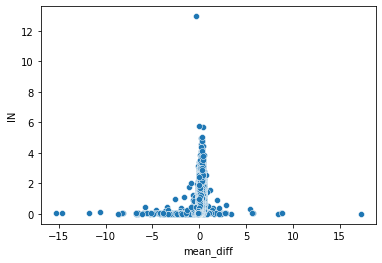

In [119]:
sns.scatterplot(data=df_atac_hic, y='IN', x='mean_diff')

<AxesSubplot:xlabel='mean_diff', ylabel='EX'>

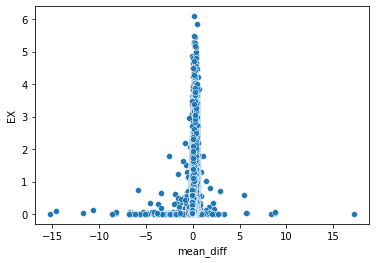

In [120]:
sns.scatterplot(data=df_atac_hic, y='EX', x='mean_diff')

<AxesSubplot:xlabel='EX', ylabel='mean_diff'>

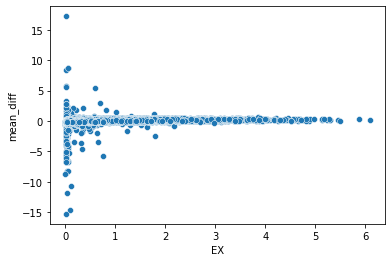

In [122]:
sns.scatterplot(data=df_atac_hic, y='mean_diff', x='EX')

In [137]:
df_atac_hic

gene  Glutamatergic  GABAergic  tp_sum_pre    g_diff  \
0       chr10_100       0.208301   0.195570           3  0.012731   
1      chr10_1000       1.135823   0.791817           4  0.344006   
2      chr10_1001       0.649726   0.351260           3  0.298466   
3      chr10_1002       0.995904   0.687227           3  0.308676   
4      chr10_1003       0.723556   0.491063           3  0.232493   
...           ...            ...        ...         ...       ...   
59978    chr9_995       0.019965   0.029229           1 -0.009263   
59979    chr9_996       0.020072   0.029121           1 -0.009049   
59980    chr9_997       0.026536   0.048936           2 -0.022400   
59981    chr9_998       0.034036   0.036396           3 -0.002360   
59982    chr9_999       0.022307   0.037519           2 -0.015211   

       tp_sum_pre2          id  P_val_agg  mean_diff class  \
0                1   chr10_100   0.301314   0.053215  gaba   
1                0  chr10_1000   0.350710   0.019022  gaba   
2                1  chr10_1001   0.085632   0.061831  gaba   
3                1  chr10_1002   0.000667   0.149677  gaba   
4                1  chr10_1003   0.004303   0.172839  gaba   
...            ...         ...        ...        ...   ...   
59978            1    chr9_995   0.993718  -0.115544  gaba   
59979            1    chr9_996   0.969247  -0.096010  gaba   
59980            1    chr9_997   0.935649  -0.070672  gaba   
59981            1    chr9_998   0.891664  -0.072130  gaba   
59982            1    chr9_999   0.980782  -0.097212  gaba   

       adjusted_P_val_agg  true_pos  true_neg         p  mean_diff_abs  
0                0.803027         0         1  0.196973       0.196973  
1                0.896871         0         1  0.103129       0.103129  
2                0.315218         0         1  0.684782       0.684782  
3                0.059852         0         1  0.940148       0.940148  
4                0.071238         0         1  0.928762       0.928762  
...                   ...       ...       ...       ...            ...  
59978            0.999996         0         1  0.000004       0.000004  
59979            0.999996         0         1  0.000004       0.000004  
59980            0.999996         0         1  0.000004       0.000004  
59981            0.999996         0         1  0.000004       0.000004  
59982            0.999996         0         1  0.000004       0.000004  

[59983 rows x 15 columns]

(0.0, 4.0)

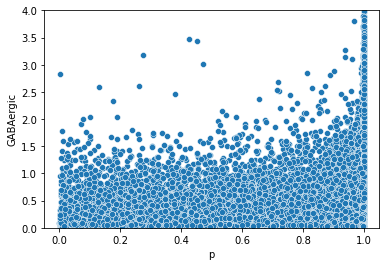

In [162]:
ax = sns.scatterplot(data=df_atac_hic, y=group1, x='p')
ax.set_ylim([0,4])

(0.0, 4.0)

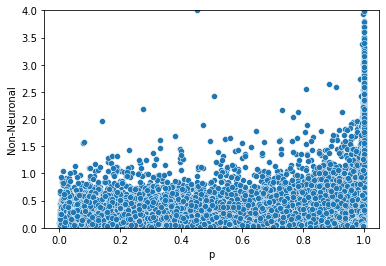

In [163]:
ax = sns.scatterplot(data=df_atac_hic, y=group2, x='p')
ax.set_ylim([0,4])

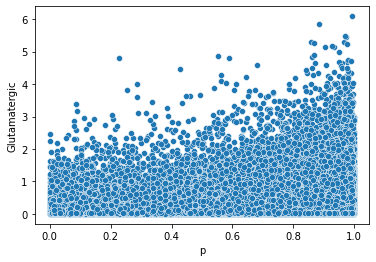

In [170]:
ax = sns.scatterplot(data=df_atac_hic, y=group2, x='p')
#ax.set_ylim([0,4])

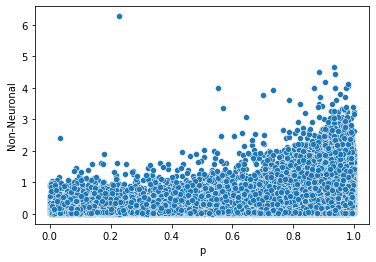

In [171]:
ax = sns.scatterplot(data=df_atac_hic, y=group1, x='p')
#ax.set_ylim([0,4])

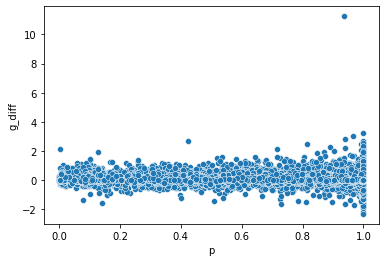

In [165]:
ax = sns.scatterplot(data=df_atac_hic, y='g_diff', x='p')
#ax.set_ylim([0,4])

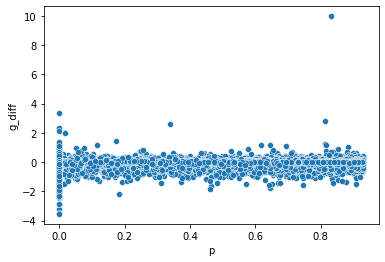

In [153]:
ax = sns.scatterplot(data=df_atac_hic, y='g_diff', x='p')
#ax.set_ylim([0,4])

<AxesSubplot:xlabel='p', ylabel='g_diff'>

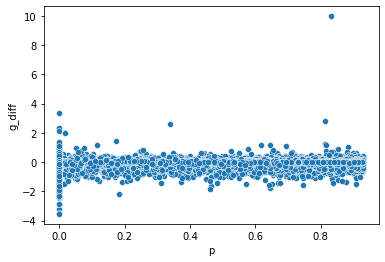

In [143]:
sns.scatterplot(data=df_atac_hic, y='g_diff', x='p')

<AxesSubplot:xlabel='p', ylabel='EX'>

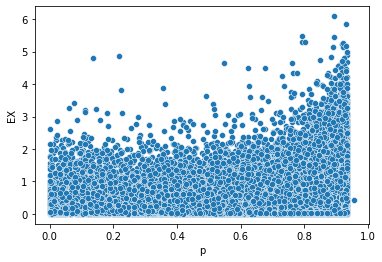

In [127]:
sns.scatterplot(data=df_atac_hic, y='EX', x='p')

<AxesSubplot:xlabel='p', ylabel='IN'>

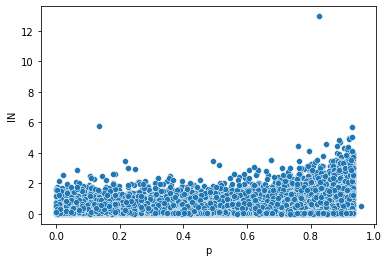

In [128]:
sns.scatterplot(data=df_atac_hic, y='IN', x='p')

<AxesSubplot:xlabel='p', ylabel='mean_diff'>

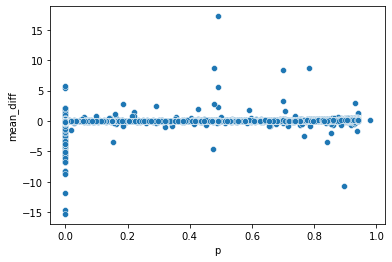

In [125]:
sns.scatterplot(data=df_atac_hic, y='mean_diff', x='p')

In [92]:
df = pd.DataFrame(df_result_list, columns = ['set1', 'set2', '#genes', 'AUC1', 'AUC2', 'thresh', 'tt', 'sig_bins', 'AUCatac']) 



In [93]:
df

set1           set2  #genes      AUC1      AUC2  thresh     tt  \
0       GABAergic   Non-Neuronal      50  0.715515  0.719213       4   5965   
1       GABAergic   Non-Neuronal     100  0.647315  0.645950       4   5965   
2       GABAergic   Non-Neuronal     200  0.642961  0.648461       4   5965   
3       GABAergic  Glutamatergic      50  0.641087  0.641727       4   6278   
4       GABAergic  Glutamatergic     100  0.473785  0.468531       4   6278   
5       GABAergic  Glutamatergic     200  0.550445  0.507968       4   6278   
6    Non-Neuronal      GABAergic      50  0.719213  0.715515       4    344   
7    Non-Neuronal      GABAergic     100  0.645950  0.647315       4    344   
8    Non-Neuronal      GABAergic     200  0.648461  0.642961       4    344   
9    Non-Neuronal  Glutamatergic      50  0.578366  0.610672       4   1006   
10   Non-Neuronal  Glutamatergic     100  0.628016  0.634323       4   1006   
11   Non-Neuronal  Glutamatergic     200  0.583653  0.583034       4   1006   
12  Glutamatergic      GABAergic      50  0.641727  0.641087       4   3893   
13  Glutamatergic      GABAergic     100  0.468531  0.473785       4   3893   
14  Glutamatergic      GABAergic     200  0.507968  0.550445       4   3893   
15  Glutamatergic   Non-Neuronal      50  0.610672  0.578366       4  12483   
16  Glutamatergic   Non-Neuronal     100  0.634323  0.628016       4  12483   
17  Glutamatergic   Non-Neuronal     200  0.583034  0.583653       4  12483   

    sig_bins   AUCatac  
0      14738  0.495962  
1      16226  0.503597  
2      24498  0.496028  
3          0  0.363164  
4          0  0.449831  
5          0  0.419776  
6      13026  0.795192  
7      12407  0.789285  
8      17262  0.797751  
9          0  0.627036  
10      3010  0.691757  
11      7166  0.689519  
12         1  0.750559  
13         0  0.644127  
14         0  0.697811  
15         0  0.530168  
16      4325  0.542738  
17      6114  0.539516

In [65]:
df_max_gene_whole_by_bins.div(df_max_gene_whole_by_bins.mean(axis=1), axis=0)

chr1_0  chr1_1  chr1_2  chr1_3  chr1_4  chr1_5  chr1_6  \
ENSMUSG00000102693     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ENSMUSG00000064842     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ENSMUSG00000051951     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ENSMUSG00000102851     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
ENSMUSG00000103377     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...                    ...     ...     ...     ...     ...     ...     ...   
ENSMUSG00000070263     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
ENSMUSG00000094649     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
ENSMUSG00000069475     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
ENSMUSG00000059326     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
ENSMUSG00000095993     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                    chr1_7  chr1_8  chr1_9  ...  chr19_1526  chr19_1527  \
ENSMUSG00000102693     NaN     NaN     NaN  ...    0.877218    0.784612   
ENSMUSG00000064842     NaN     NaN     NaN  ...    0.972687    0.811725   
ENSMUSG00000051951     NaN     NaN     NaN  ...    0.783014    0.826660   
ENSMUSG00000102851     NaN     NaN     NaN  ...    0.623421    0.817148   
ENSMUSG00000103377     NaN     NaN     NaN  ...    0.722110    0.822027   
...                    ...     ...     ...  ...         ...         ...   
ENSMUSG00000070263     0.0     0.0     0.0  ...         NaN         NaN   
ENSMUSG00000094649     0.0     0.0     0.0  ...         NaN         NaN   
ENSMUSG00000069475     0.0     0.0     0.0  ...         NaN         NaN   
ENSMUSG00000059326     0.0     0.0     0.0  ...         NaN         NaN   
ENSMUSG00000095993     0.0     0.0     0.0  ...         NaN         NaN   

                    chr19_1528  chr19_1529  chr19_1530  chr19_1531  \
ENSMUSG00000102693    0.622378    1.273805    0.817336    1.061519   
ENSMUSG00000064842    0.585095    1.597022    1.055832    1.497945   
ENSMUSG00000051951    0.765600    0.821371    1.178905    0.978658   
ENSMUSG00000102851    0.720006    0.574461    1.028600    1.114097   
ENSMUSG00000103377    0.968972    1.172980    0.927395    0.891299   
...                        ...         ...         ...         ...   
ENSMUSG00000070263         NaN         NaN         NaN         NaN   
ENSMUSG00000094649         NaN         NaN         NaN         NaN   
ENSMUSG00000069475         NaN         NaN         NaN         NaN   
ENSMUSG00000059326         NaN         NaN         NaN         NaN   
ENSMUSG00000095993         NaN         NaN         NaN         NaN   

                    chr19_1532  chr19_1533  chr19_1534  chr19_1535  
ENSMUSG00000102693    0.820885    0.626211         0.0         0.0  
ENSMUSG00000064842    0.934177    1.018050         0.0         0.0  
ENSMUSG00000051951    0.882869    0.824107         0.0         0.0  
ENSMUSG00000102851    0.617556    0.892613         0.0         0.0  
ENSMUSG00000103377    0.687804    0.441845         0.0         0.0  
...                        ...         ...         ...         ...  
ENSMUSG00000070263         NaN         NaN         NaN         NaN  
ENSMUSG00000094649         NaN         NaN         NaN         NaN  
ENSMUSG00000069475         NaN         NaN         NaN         NaN  
ENSMUSG00000059326         NaN         NaN         NaN         NaN  
ENSMUSG00000095993         NaN         NaN         NaN         NaN  

[50225 rows x 61578 columns]

In [103]:
df_atac['IN'].max() (gaba)

12.945985200480001

In [107]:
df_atac

gene        IN        EX  tp_sum_pre    g_diff  tp_sum_pre2
0       chr10_100  0.195570  0.208301           3  0.012731            1
1      chr10_1000  0.791817  1.135823           4  0.344006            0
2      chr10_1001  0.351260  0.649726           3  0.298466            1
3      chr10_1002  0.687227  0.995904           3  0.308676            1
4      chr10_1003  0.491063  0.723556           3  0.232493            1
...           ...       ...       ...         ...       ...          ...
64129    chrX_995  0.035191  0.036941           2  0.001750            1
64130    chrX_996  0.022134  0.016205           1 -0.005929            1
64131    chrX_997  0.023668  0.015875           1 -0.007794            1
64132    chrX_998  0.037956  0.020339           0 -0.017617            2
64133    chrX_999  0.044182  0.022142           0 -0.022040            2

[64134 rows x 6 columns]

In [104]:
df_atac['EX'].max() (gluata)

6.088765020699999

In [105]:
df_atac['IN'].mean()

0.33290990814018856

In [106]:
df_atac['EX'].mean() 

0.3955271123668317

In [68]:
df_max_gene_whole_by_bins.mean(axis=1, skipna=True)

ENSMUSG00000102693    23.848776
ENSMUSG00000064842    23.848658
ENSMUSG00000051951    34.057705
ENSMUSG00000102851    23.848789
ENSMUSG00000103377    23.848669
                        ...    
ENSMUSG00000070263    22.517809
ENSMUSG00000094649    22.517809
ENSMUSG00000069475    22.517809
ENSMUSG00000059326    22.517799
ENSMUSG00000095993    22.517817
Length: 50225, dtype: float32

In [69]:
a = np.array([[1, 2], [3, 4]])

In [73]:
a.mean(axis=0)

array([2., 3.])

In [61]:
df_max_gene_whole_by_bins[df_max_gene_whole_by_bins.columns.isin(marker_table.index.tolist())]

ValueError: Item wrong length 61578 instead of 50225.

In [63]:
marker_table.index.tolist()

['ENSMUSG00000002985',
 'ENSMUSG00000005360',
 'ENSMUSG00000007097',
 'ENSMUSG00000022708',
 'ENSMUSG00000026421',
 'ENSMUSG00000026787',
 'ENSMUSG00000027199',
 'ENSMUSG00000027447',
 'ENSMUSG00000036766',
 'ENSMUSG00000037610',
 'ENSMUSG00000039607',
 'ENSMUSG00000040260',
 'ENSMUSG00000053519',
 'ENSMUSG00000058975',
 'ENSMUSG00000062078',
 'ENSMUSG00000062209',
 'ENSMUSG00000070880',
 'ENSMUSG00000090063',
 'ENSMUSG00000092274',
 'ENSMUSG00000096914',
 'ENSMUSG00000098326',
 'ENSMUSG00000111138']

In [62]:
df_max_gene_whole_by_bins.columns

Index(['chr1_0', 'chr1_1', 'chr1_2', 'chr1_3', 'chr1_4', 'chr1_5', 'chr1_6',
       'chr1_7', 'chr1_8', 'chr1_9',
       ...
       'chr19_1526', 'chr19_1527', 'chr19_1528', 'chr19_1529', 'chr19_1530',
       'chr19_1531', 'chr19_1532', 'chr19_1533', 'chr19_1534', 'chr19_1535'],
      dtype='object', length=61578)

In [93]:
df_optimal_marker = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/optimal_number_markers.csv')
df_optimal_marker[df_optimal_marker['marker_set'] == 'Pvalb']



hierarchy_level marker_set  n_genes        f1
1288        subclass      Pvalb        1  0.780280
1289        subclass      Pvalb        2  0.909541
1290        subclass      Pvalb        5  0.955372
1291        subclass      Pvalb       10  0.965347
1292        subclass      Pvalb       20  0.972673
1293        subclass      Pvalb       50  0.972867
1294        subclass      Pvalb      100  0.972739
1295        subclass      Pvalb      200  0.959557
1296        subclass      Pvalb      500  0.951210
1297        subclass      Pvalb     1000  0.926475
1298        subclass      Pvalb     2000  0.950225
1299        subclass      Pvalb     5000  0.904615
1300        subclass      Pvalb    10000  0.932137

In [2]:
marker_list 

NameError: name 'marker_list' is not defined

In [84]:
df_optimal_marker = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/optimal_number_markers.csv')
df_optimal_marker = df_optimal_marker[df_optimal_marker['n_genes'] >= 10]
df_optimal_marker = df_optimal_marker[df_optimal_marker['f1'] <= 0.8]
#df_optimal_marker = df_optimal_marker[df_optimal_marker['f1'] >= 0.8]
df_optimal_marker = df_optimal_marker.loc[df_optimal_marker.groupby('marker_set')['f1'].idxmax()]
#df_optimal_marker = df_optimal_marker.loc[df_optimal_marker.groupby('marker_set')['f1'].idxmin()]
marker_list_optimal_marker = []
for marker, n_genes in zip(df_optimal_marker['marker_set'].tolist(), df_optimal_marker['n_genes'].tolist()):
    #print (n_genes)
    
    marker_list_optimal_marker.append(marker_list[(marker_list['cell_type'] == marker) & (marker_list['rank'] <= n_genes)])
    
marker_list = pd.concat(marker_list_optimal_marker)

In [85]:
df_optimal_marker

hierarchy_level      marker_set  n_genes        f1
1180        subclass         L2/3 IT     1000  0.726512
44     joint_cluster       L2/3 IT_1       50  0.517432
59     joint_cluster       L2/3 IT_2      200  0.548169
99     joint_cluster       L4/5 IT_1     5000  0.761495
112    joint_cluster       L4/5 IT_2     5000  0.739207
...              ...             ...      ...       ...
1110   joint_cluster    Vip Mybpc1_3       20  0.594133
1123   joint_cluster  Vip Serpinf1_1       20  0.414391
1140   joint_cluster  Vip Serpinf1_2      500  0.721014
1150   joint_cluster  Vip Serpinf1_3       50  0.566260
1166   joint_cluster        Vip Sncg      500  0.775557

[91 rows x 4 columns]

In [ ]:
marker_list_optimal_marker = []
for marker, n_genes in zip(df_optimal_marker['marker_set'].tolist(), df_optimal_marker['n_genes'].tolist()):
    #print (n_genes)
    
    marker_list_optimal_marker.append(marker_list[(marker_list['cell_type'] == marker) & (marker_list['rank'] <= n_genes)])
    
marker_list = pd.concat(marker_list_optimal_marker)

In [73]:
df = pd.DataFrame(df_result_list, columns = ['set1', 'set2', '#genes', 'AUC1', 'AUC2', 'exp']) 

In [67]:
df = df[df['exp'] == 'exp']

In [74]:
df['sets'] = df['set1'] + df['set2']

<AxesSubplot:xlabel='#genes', ylabel='AUC2'>

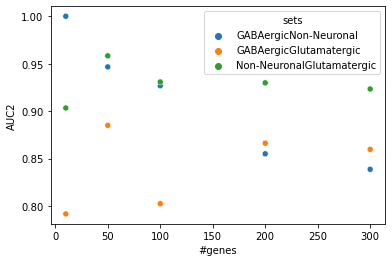

In [47]:
sns.scatterplot(data=df, x='#genes', y='AUC2', hue='sets') 

<AxesSubplot:xlabel='#genes', ylabel='AUC2'>

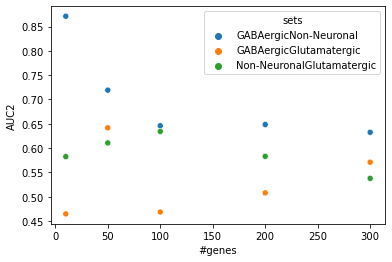

In [39]:
sns.scatterplot(data=df, x='#genes', y='AUC2', hue='sets') 

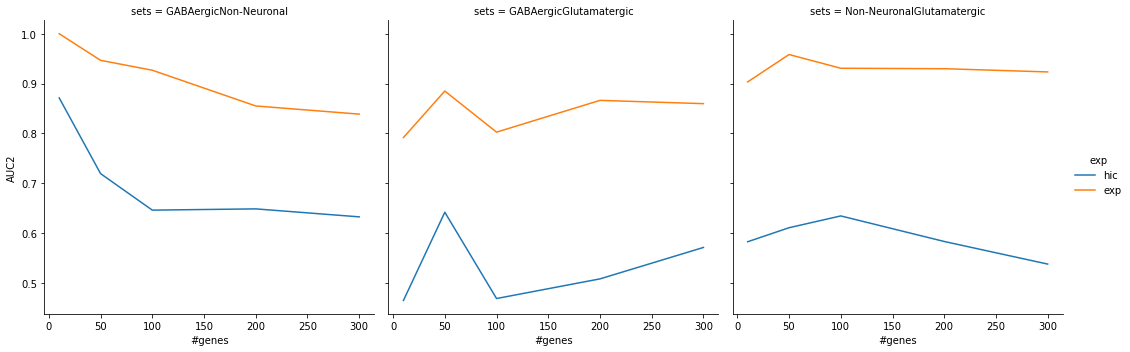

In [54]:
sns.relplot(
    data=df, x="#genes", y="AUC2",
    col="sets", hue="exp", 
    kind="line"
)

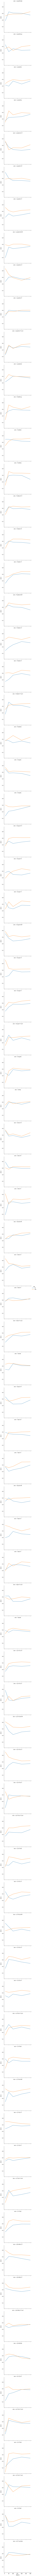

In [75]:
sns.relplot(
    data=df, x="#genes", y="AUC2",
    row="sets", hue="exp", 
    kind="line"
)

In [72]:
df

set1   set2  #genes      AUC1      AUC2  exp           sets
1         Lamp5  Pvalb      10  0.354938  0.522222  exp     Lamp5Pvalb
3         Lamp5  Pvalb      50  0.542604  0.564836  exp     Lamp5Pvalb
5         Lamp5  Pvalb     100  0.618136  0.581988  exp     Lamp5Pvalb
7         Lamp5  Pvalb     200  0.644148  0.583386  exp     Lamp5Pvalb
9         Lamp5  Pvalb     300  0.645226  0.650578  exp     Lamp5Pvalb
..          ...    ...     ...       ...       ...  ...            ...
771  L6 IT Car3    L6b      10  0.477778  0.488889  exp  L6 IT Car3L6b
773  L6 IT Car3    L6b      50  0.526843  0.580628  exp  L6 IT Car3L6b
775  L6 IT Car3    L6b     100  0.582661  0.546685  exp  L6 IT Car3L6b
777  L6 IT Car3    L6b     200  0.531301  0.550405  exp  L6 IT Car3L6b
779  L6 IT Car3    L6b     300  0.584796  0.584211  exp  L6 IT Car3L6b

[390 rows x 7 columns]

In [78]:
df_merge = df[df['exp'] != 'exp'].merge(df[df['exp'] == 'exp'], on=['set1', 'set2', '#genes', 'sets'])

In [79]:
df_merge

set1   set2  #genes    AUC1_x    AUC2_x exp_x           sets  \
0         Lamp5  Pvalb      10  0.391667  0.375000   hic     Lamp5Pvalb   
1         Lamp5  Pvalb      50  0.622499  0.647738   hic     Lamp5Pvalb   
2         Lamp5  Pvalb     100  0.617953  0.613647   hic     Lamp5Pvalb   
3         Lamp5  Pvalb     200  0.606212  0.605316   hic     Lamp5Pvalb   
4         Lamp5  Pvalb     300  0.554414  0.551424   hic     Lamp5Pvalb   
..          ...    ...     ...       ...       ...   ...            ...   
385  L6 IT Car3    L6b      10  0.231481  0.477778   hic  L6 IT Car3L6b   
386  L6 IT Car3    L6b      50  0.587702  0.633951   hic  L6 IT Car3L6b   
387  L6 IT Car3    L6b     100  0.620299  0.629762   hic  L6 IT Car3L6b   
388  L6 IT Car3    L6b     200  0.601927  0.590750   hic  L6 IT Car3L6b   
389  L6 IT Car3    L6b     300  0.567804  0.569290   hic  L6 IT Car3L6b   

       AUC1_y    AUC2_y exp_y  
0    0.354938  0.522222   exp  
1    0.542604  0.564836   exp  
2    0.618136  0.581988   exp  
3    0.644148  0.583386   exp  
4    0.645226  0.650578   exp  
..        ...       ...   ...  
385  0.477778  0.488889   exp  
386  0.526843  0.580628   exp  
387  0.582661  0.546685   exp  
388  0.531301  0.550405   exp  
389  0.584796  0.584211   exp  

[390 rows x 10 columns]

<AxesSubplot:xlabel='AUC1_x', ylabel='AUC1_y'>

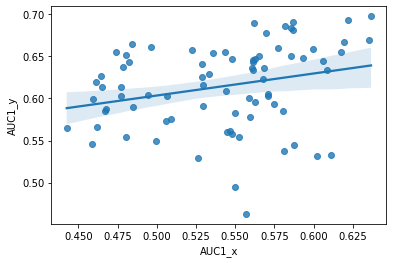

In [111]:
sns.regplot(
    data=df_merge[df_merge['#genes']==200], y="AUC1_y", x="AUC1_x",

)

<AxesSubplot:xlabel='AUC2_x', ylabel='AUC2_y'>

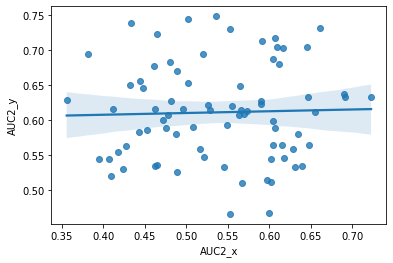

In [107]:
sns.regplot(
    data=df_merge[df_merge['#genes']==50], x="AUC2_x", y="AUC2_y",

)